<h1> Objective: Bringing the log loss to less than 1.0 </h1>

<h3> Approach used for Vectorization of data : </h3>
<ul>
    <li> Response code Gene and Variation feature.</li> 
    <li> Took top 10k words for text feature with TF-IDF.</li> 
<ul>

<h3> Feature Engineering: </h3>
<ul>
      <li> Tried mathematical transformation with gene feature. Applied log as it follows pareto distribution but the log loss was not reduced to less than 1.0 </li> 
    <li> Tried word2Vec with text feature but the results were the same </li> 
<ul>

<h3> Findings : </h3>
<ol>
    <li> The train log loss is: 0.6498203809007842 </li>
    <li> The cross validation log loss is: 0.9940385572200611 </li>
    <li> The test log loss is: 0.9502154091730729 </li>
    <li> Mis-classified points % = 34.88 </li>
</ol>

<h3> This is the best model till now because : </h3>
<ol>
    <li> The main metric i.e log loss is decreased and is now  less than 1.0 </li>
    <li> Both the cv log loss and tess log loss have decreased </li>
    <li> The gap between train , cv and test log loss has decreased, hence the chances of over fitting has reduced </li>
    <li> The percentage of Mis-classified points is the lowest till now </li>
</ol>


In [31]:
import pandas as pd
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.preprocessing import normalize
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


In [3]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        # replace every special char with space
        if type(total_text) is not float:
            string = ""
            total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
            # replace multiple spaces with single space
            total_text = re.sub('\s+',' ', total_text)
            # converting all the chars into lower-case.
            total_text = total_text.lower()

            for word in total_text.split():
            # if the word is a not a stop word then retain that word from the data
                if not word in stop_words:
                    string += word + " "

            data_text[column][index] = string

In [5]:
#text processing stage.
for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')

In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
np.array(np.where(result['TEXT'].isnull().values==True))

array([[1109, 1277, 1407, 1639, 2755]], dtype=int64)

In [8]:
for i in np.array(np.where(result['TEXT'].isnull().values==True)):
    result['TEXT'][i]='empty'

In [9]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [35]:
def logisticRegression(train_x,cv_x,text_x):
    alpha = [10 ** x for x in range(-7, 1)] # hyperparam for SGD classifier.
    cv_log_error_array=[]
    for i in alpha:
        clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2', loss='log', random_state=42)
        clf.fit(train_x, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, y_train)
        predict_y = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
        print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

    best_alpha = np.argmin(cv_log_error_array)
    clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, y_train)

    predict_y = sig_clf.predict_proba(train_x)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(cv_x)
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(text_x)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    
     # calculating the number of data points that are misclassified
    predict_y = sig_clf.predict(test_x)
    print("Number of mis-classified points :", np.count_nonzero((predict_y- y_test))/y_test.shape[0])
    plot_confusion_matrix(y_test, predict_y)

In [32]:
# This function plots the confusion, precision and recall matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A = (((C.T)/(C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    # representing C in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing A in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<h3> Vectorizing the features </h3>

<h3> A. Top words of text from TF-IDF </h3>

In [11]:
def getTopWordsFrom_TfIdf_Value(tf_idf_vect,final_tf_idf,n):
    feature_array = np.array(tf_idf_vect.get_feature_names())
    final_tf_idf_arr=final_tf_idf.toarray().sum(axis=0)
    
    top_10k_index=np.argsort(final_tf_idf_arr)[::-1]
    top_10k_index=top_10k_index[0:n]
    complete_most_imp_words=feature_array[top_10k_index]
    most_imp_words_subset=complete_most_imp_words[0:n]
    
    return most_imp_words_subset,top_10k_index

In [13]:
tf_idf_vect = TfidfVectorizer(min_df=3)
train = tf_idf_vect.fit_transform(train_df['TEXT'])
cv = tf_idf_vect.transform(cv_df['TEXT'])
test = tf_idf_vect.transform(test_df['TEXT'])

In [14]:
top10k_words_train,top_10k_index=getTopWordsFrom_TfIdf_Value(tf_idf_vect,train,10000)

In [15]:
print('Top 5 words : %s' %(top10k_words_train[0:5]))

train_text_feature = train[:,top_10k_index]
cv_text_feature = cv[:,top_10k_index]
test_text_feature = test[:,top_10k_index]

print("Number of words in train data = ", train_text_feature.shape)
print("Number of words in test data = ", test_text_feature.shape)
print("Number of words in cross validation data =", cv_text_feature.shape)

Top 5 words : ['mutations' 'brca1' 'cells' 'variants' 'fig']
Number of words in train data =  (2124, 10000)
Number of words in test data =  (665, 10000)
Number of words in cross validation data = (532, 10000)


<h3> B. Response coding for Gene and Variation Feature </h3>

In [16]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [17]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [18]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

<h3> Stacking the features </h3>

In [19]:
from scipy.sparse import hstack
train_gene_var= np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x = hstack((train_gene_var, train_text_feature))#.tocsr()
test_x = hstack((test_gene_var, test_text_feature))#.tocsr()
cv_x = hstack((cv_gene_var, cv_text_feature))#.tocsr()

<h3> Applying Logistic Regression </h3>

For values of alpha =  1e-07 The log loss is: 1.1115163914768118
For values of alpha =  1e-06 The log loss is: 1.1037863128892071
For values of alpha =  1e-05 The log loss is: 1.065235933530434
For values of alpha =  0.0001 The log loss is: 0.9940385572200611
For values of alpha =  0.001 The log loss is: 1.0500303160188704
For values of alpha =  0.01 The log loss is: 1.1674956603790365
For values of alpha =  0.1 The log loss is: 1.3677044511371577
For values of alpha =  1 The log loss is: 1.5189371736123303


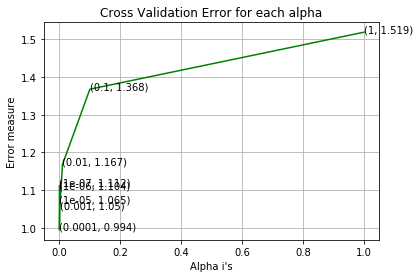

For values of best alpha =  0.0001 The train log loss is: 0.6498203809007842
For values of best alpha =  0.0001 The cross validation log loss is: 0.9940385572200611
For values of best alpha =  0.0001 The test log loss is: 0.9502154091730729
Number of mis-classified points : 0.34887218045112783
-------------------- Confusion matrix --------------------


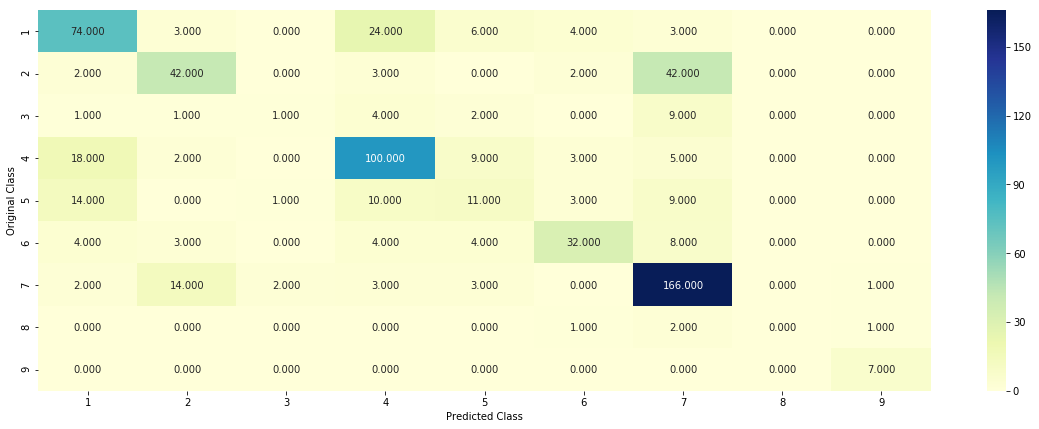

-------------------- Precision matrix (Columm Sum=1) --------------------


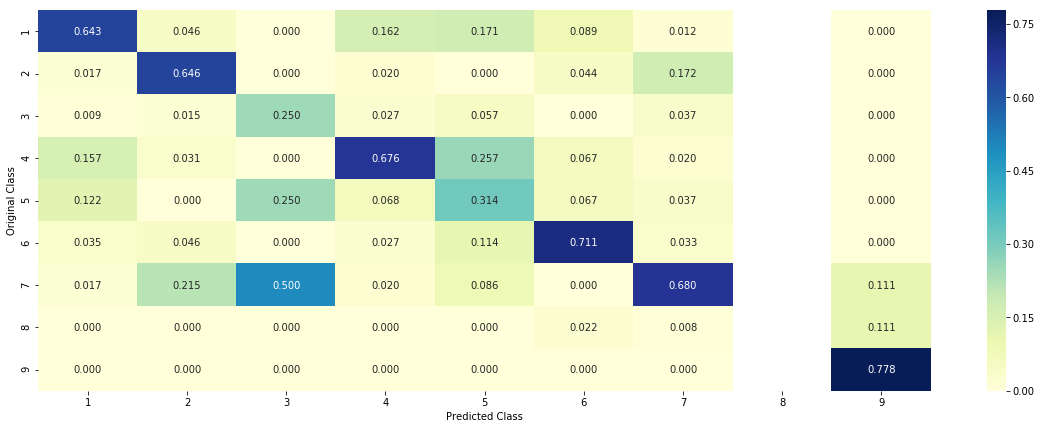

-------------------- Recall matrix (Row sum=1) --------------------


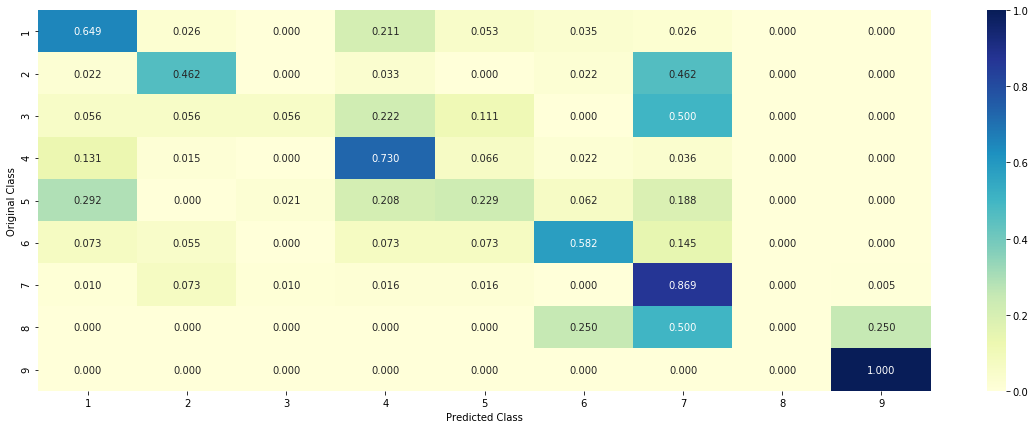

In [36]:
logisticRegression(train_x,cv_x,test_x)